In [2]:
%load_ext autoreload
%autoreload 2
from itertools import product
from os import path
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from numba import jit, prange
from tqdm.auto import tqdm
from utils import get_single_run
from sparseDynamicRecon.fidelity import GaussianGrid

import warnings; warnings.filterwarnings("ignore", message=".*a non-GUI backend")
    
from IPython.display import display, Image, HTML

SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 16, 20, 24
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('figure', dpi=100)
plt.rc('figure', figsize=(18,10))

def figure(name, *args, figsize=(9.5,6), **kwargs):
    plt.close(name)
    f = plt.figure(name, *args, figsize=figsize, **kwargs)
    return f
def show(): plt.tight_layout()

SECS, MINS, HOURS = (1,'seconds'), (60,'minutes'), (60*60, 'hours')

## Load and normalise data

In [6]:
try:
    with np.load(path.join('data', 'Quantum Dots', 'Human.npz')) as f:
        data, T = f['data'], f['T']
except FileNotFoundError:
    import tifffile
    data = tifffile.imread(path.join('data', 'Quantum Dots', 'confocal', 'Human.tif'))
    T = np.linspace(0, 1, data.shape[0])

data = data / data.max()
# assume equispaced samples in time and space
dt, dx = T[1] - T[0], max(1 / (data.shape[1] - 1), 1 / (data.shape[2] - 1))

(1000, 600, 600)
(1000, 600, 600)


## Compute data normalisation
We shift and rescale to have zero-mean noise and maximum signal of 1.

In [3]:
# from scipy.optimize import minimize
# from scipy.special import erf
# # # Identify pure noise regions: data.max(0) < 0.33
# # plt.plot(np.sort(data.max(0).ravel())); plt.show()
#
# arr = data[:, data.max(0) < 0.33].ravel()  # all observations in pixels which are all noise
# bins = np.unique(arr)  # identify bin centers based on discretised image
# bins = .5 * np.concatenate(([3 * bins[0] - bins[1]], bins[1:] + bins[:-1], [3 * bins[-1] - bins[-2]]))
# heights, bins, _ = plt.hist(arr, bins=bins, density=True)
# def fit(x):
#     m, s = x  # mean and standard deviation
#     cum = .5 * (1 + erf((bins - m) / (2**.5 * s)))
#     vals = (cum[1:] - cum[:-1])
#     return abs(vals / vals.sum() - heights / heights.sum()).sum()
# x = np.array([arr.mean(), arr.std()])
# res = minimize(fit, x, bounds=((x[0] - 3 * x[1], x[0] + 3 * x[1]), (x[1] / 2, x[1] * 2)))
# m, std = res.x
# print(res.message, '%e' % fit(res.x))
# print('mean = ', round(m, 4), ' std = ', round(std, 5))  # = 0.295, 0.00572
# x = np.linspace(bins[0], bins[-1], 1000)
# y = np.exp(-(x - m)**2 / (2 * std**2))
# plt.plot(x, y * heights.mean() / y.mean()); plt.show()
mean, std = .295, .00572
if data.min()>-.01: # prevents the normalisation being applied twice
    data = (data - mean)/(1 - mean)
mean, std = 0, std / (1 - mean)

## Model
We propose the model:
$$step(m,x,s,M,X,S) = \left(\alpha(S-s) + \frac{\beta}{2}\frac{(X-x)^2}{S-s} \right)\frac{m+M}{2} + \frac{\gamma}{2}\frac{|M^{1/p}-m^{1/p}|^p}{{(S-s)^{p-1}}}$$
for some p>1.
(p=2 is not quite WFR because there isn't a cosine term)  
For consistency with the paper we will say $(w_0,w_1,w_2) = (\alpha,\beta,\gamma)$


In [13]:
weight = [1e-4, 1e-5, 1e-8]  # default mass, velocity, and mass change penalties
max_velocity = 25  # maximum number of pixels to move in one frame
max_velocity *= dx/dt  # rescale to correct units
FWHM = 3; radius = FWHM / (4 * np.log(2))**.5  # radius of Gaussian in pixel units
radius *= dx  # rescale to correct units
# # check radius on data
# from sparseDynamicRecon import DynamicMeasureSpace, CurveSpace
# mySlice = slice(104, 104+100), slice(128, 128+100)
# Fidelity = GaussianGrid((dx, dx), radius, 0, data=data[:2,mySlice[0],mySlice[1]])
# tmp = DynamicMeasureSpace(CurveSpace(dim=2, T=T[:2], balanced=True),1).zero()+50*dx
# tmp = Fidelity.fwrd(tmp)[0]
# plt.imshow(data[0,mySlice[0],mySlice[1]]*(tmp<.001)+.2*data.max()/tmp.max()*tmp,vmin=0)

NameError: name 'DynamicMeasureSpace' is not defined

## Code for single reconstruction and saving outputs

In [5]:
single_run = get_single_run(('results', 'Human'), weight, dx, FWHM, max_velocity)

# Perform the reconstructions with varying weights

In [24]:
p = 2 # order of penalty of mass-change
weights = (.3,1,3,10), (.3,1,3), (.1,1,10); Iters = (20.2,)
# weights = (3,10), (1,), (1,10); Iters = (1000.2,)
# p = 1.1; Iters = (10,20.2,)
# I = max(i for i in Iters if np.isclose(i%1,0)) # the largest number of 'normal' iterates
I = max(Iters) # hopefully most converged reconstructions

Weights = tuple(product(*weights))
mySlice = (slice(100), slice(104, 104+128), slice(128, 128+128))
small_data = np.ascontiguousarray(data[mySlice])
small_T = np.ascontiguousarray(T[mySlice[0]])
np.savez_compressed('Human_small.npz', data=small_data, T=small_T, 
    extras=dict(directory=('results', 'Human'), weight=weight, dx=dx, FWHM=FWHM, max_velocity=max_velocity))

datafile = path.join('results', 'Human', 'data-' + '-'.join(str(d) for d in small_data.shape) + '.gif')
Fidelity = GaussianGrid((dx, dx), radius, 0, data=small_data)
if not path.exists(datafile):
    Fidelity.gif(datafile,scale=4*255)

fname, recon, cback, label, line_param = {}, {}, {}, {}, {}
for z in tqdm(list(product(Weights,Iters)), ncols=800):
    w, iters = z
    fname[z], recon[z], cback[z] = single_run(small_data, small_T, w, iters, p)
#     Fidelity.gif(fname[z]['gif'], recon[z], scale=4*255)
#     Fidelity.gif(fname[z]['trace'], recon[z], scale=4*255, trace=1, trace_thresh=[.01*r for r in (.99,1)])
    label[z] = '(%.1f, %.1f, %.3f) '%w + ('coarse-to-fine' if int(iters)==iters else 'slow-to-fast')
    tmp = weights[0].index(w[0]) + len(weights[0])*(weights[1].index(w[1]) + len(weights[1])*weights[2].index(w[2])), Iters.index(iters)
    line_param[z] = {
        'color':'tab:'+('blue','orange','green','red','purple')[tmp[0]%5],
        'marker':' o^Dp*x>'[tmp[0]//5],
        'linestyle':(0,[(1,2),(3,2),(6,2),(6,2,1,2),(6,2,3,2)][tmp[-1]]),
    }

  0%|                                                                                                         …

In [17]:
HTML(f'<h1>Raw data</h1><img src="{datafile}" style="width:512px"> </img>')

# Plotting results
## Time and number of iterations to convergence

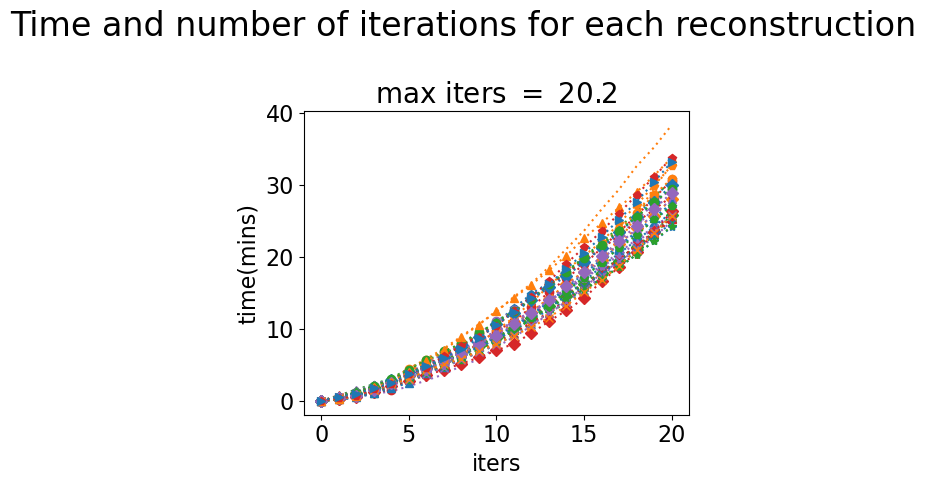

In [25]:
F = figure('converged', figsize=(5*len(Iters),5))
ax = F.subplots(1,len(Iters),sharex=True,sharey=True) if len(Iters)>1 else (F.gca(),)
for i, a in enumerate(ax):
    for z,c in cback.items():
        if z[1]==Iters[i]:
            a.plot(c.i,c.T/60, label=label[z].split(')')[0][1:], **line_param[z])
    a.set_title('max iters $ = $ %s'%Iters[i])
    a.set_xlabel('iters')
    if i==0:
        a.set_ylabel('time(mins)')
F.suptitle('Time and number of iterations for each reconstruction')
show()

## Sparsity of reconstruction

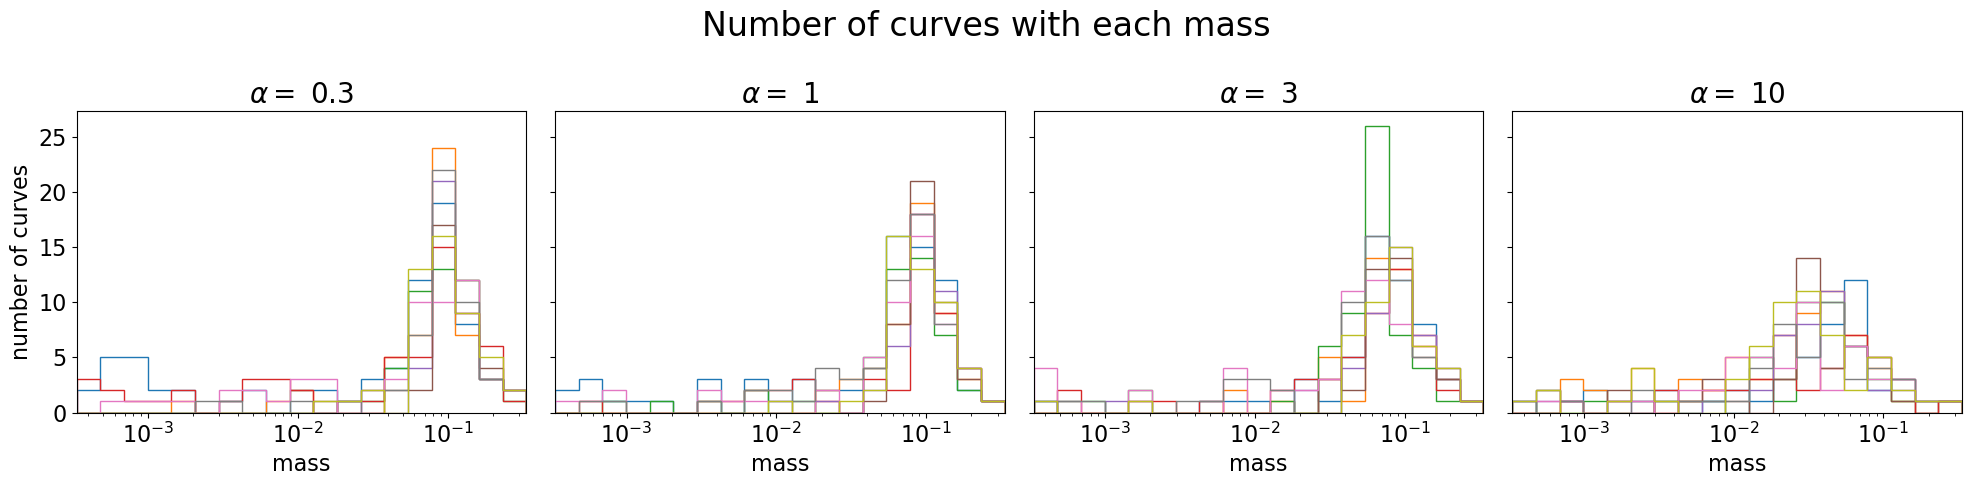

In [26]:
def masses(r):
    T = r.T; a = abs(r.a)
    if a.ndim==1:
        return a
    else:
        return .5*(a[:,1:]+a[:,:-1]).mean(1)
thresh = max(masses(r).max() for r in recon.values())
bins = np.logspace(np.log10(.001*thresh),np.log10(thresh),20)

F = figure('sparsity', figsize=(5*len(weights[0]),5))
ax = F.subplots(1,len(weights[0]), sharex=True, sharey=True) if len(weights[0])>1 else (F.gca(),)
for i, a in enumerate(ax):
    for z,r in recon.items():
        if z[0][0]==weights[0][i]:
            a.hist(masses(r),bins, histtype='step', density=False)
    a.set_title('$\\alpha = $ %s'%weights[0][i])
    a.set_xlabel('mass'); a.set_xscale('log'); a.set_xlim(bins[[0,-1]]) #a.set_yticks([]); a.set_xticklabels([])
    if i==0:
        a.set_ylabel('number of curves')
F.suptitle('Number of curves with each mass')
show()

## Step size plots

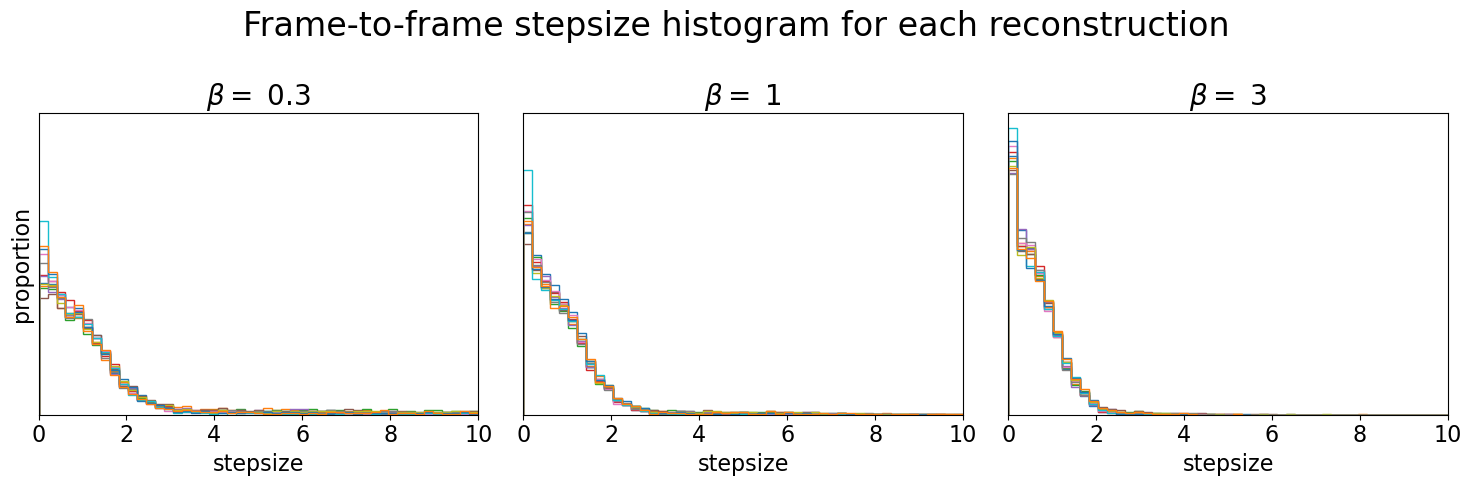

In [27]:
thresh = .01*max(r.a.max() for r in recon.values())
def vel(r):
    v = r.x[:,1:] - r.x[:,:-1] # r.shape = (N atoms, N times, 2)
    ind = (np.minimum(r.a[:,1:],r.a[:,:-1]) > thresh) # r.a.shape = (N atoms, N times)
    return (v[ind]**2).sum(axis=1)**.5
bins = np.linspace(0,10,50) # Look at jumps up to 10 pixels

F = figure('step sizes', figsize=(5*len(weights[1]),5))
ax = F.subplots(1,len(weights[1]),sharex=True,sharey=True) if len(weights[1])>1 else (F.gca(),)
for i, a in enumerate(ax):
    for z,r in recon.items():
        if z[0][1]==weights[1][i]:
#             a.plot(bins[1:], np.histogram(vel(r)/dx,bins,density=True)[0])
            a.hist(vel(r)/dx,bins, histtype='step', density=True)
    a.set_title('$\\beta = $ %s'%weights[1][i])
    a.set_xlabel('stepsize'); a.set_xlim(bins[[0,-1]]); a.set_yticks([]); #a.set_xticklabels([])
    if i==0:
        a.set_ylabel('proportion')
F.suptitle('Frame-to-frame stepsize histogram for each reconstruction')
show()

## Mass conservation plots

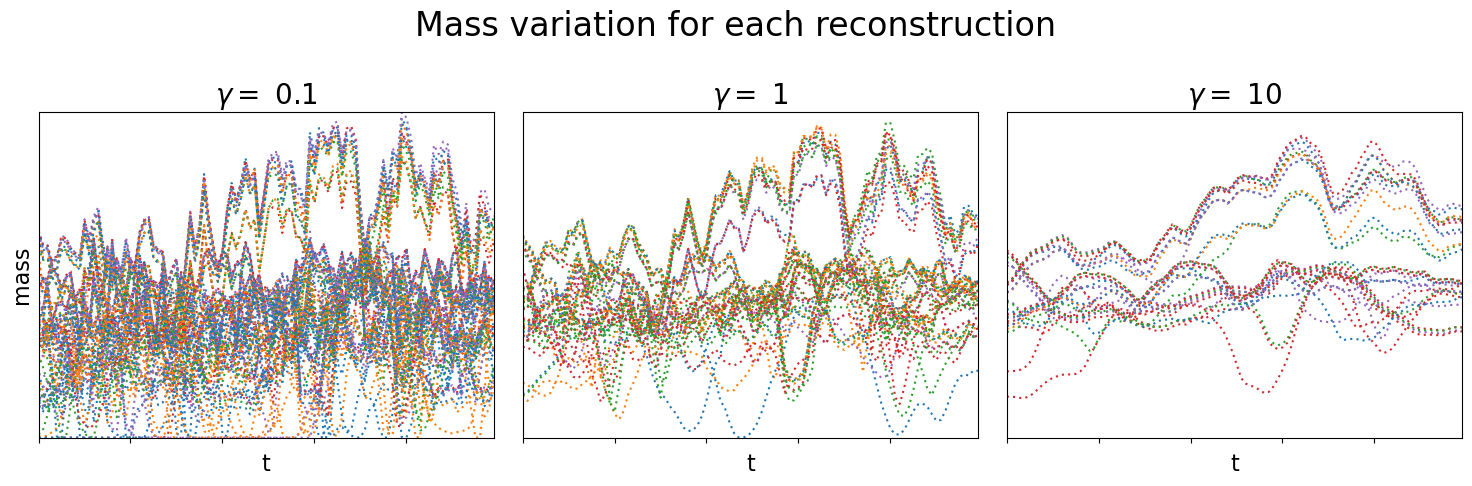

In [28]:
thresh = max(r.a.max() for r in recon.values())
F = figure('mass conservation', figsize=(5*len(weights[2]),5))
ax = F.subplots(1,len(weights[2]),sharex=True,sharey=True) if len(weights[2])>1 else (F.gca(),)
for i, a in enumerate(ax):
    for z in recon:
        if z[0][2]==weights[2][i]:
            a.plot(recon[z].T, recon[z].a[recon[z].a.max(1)>.5*thresh].T, **line_param[z], markersize=0, label=(str(z[0][:2]) if i==0 else None))
    a.set_title('$\\gamma = $ %s'%weights[2][i])
    a.set_xlabel('t'); a.set_yticks([]); a.set_xticklabels([])
    if i==0:
        a.set_ylabel('mass')
a.set_ylim(0,thresh); a.set_xlim(recon[z].T[[0,-1]]);
F.suptitle('Mass variation for each reconstruction')
show()

## Gifs of top/bottom 5 reconstructions in order of data-fidelity

In [22]:
E = {w:Fidelity(recon[(w,I)]) for w in Weights}
m,M = min(E.values()), max(E.values())
E = {w:(E[w]-m)/(M-m) for w in Weights}

def best(L,n, reverse=False):
    L = sorted(L, key=((lambda w:-E[w]) if reverse else (lambda w: E[w])))
    return L[:n]
def rowify(L,n=3):
    s, i = '', 0
    while n*i<len(L):
        s = s + '\n<tr>\n\t' + '\n\t'.join(row[w] for w in L[n*i:n*(i+1)]) + '\n</tr>'
        i += 1
    return s
def tablify(rows):
    rows = rows.replace('<img', '''<img onclick='document.querySelectorAll("table img").forEach(function (I) {I.setAttribute("src",I.src)})' ''')
    return f'<table style="width:100%;table-layout:fixed;"> {rows} </table>'
def argmin(I):
    E = {w:Fidelity(recon[(w,I)]) for w in Weights}
    Emin = min(E.values())
    return [w for w in Weights if E[w]==Emin][0], I

for s in ('gif', 'trace'):
    html = '<td> <p style="text-align:center"> %s, %.3f </p> <img src="%s" style="width:100%%"> </img> </td>'
    row = {w:html % (w,E[w],path.join(*fname[(w,I)][s])) for w in Weights}; row['GT'] = html % ('Ground-Truth',m/(M-m),datafile)
    t = ', showing ' + ('data projection' if s == 'gif' else 'trajectories')

    display(HTML('<h1> Data-space reconstructions ordered by energy. Printed energy is linearly rescaled so that reconstructions are in [0,1].</h1>'
        + f'<h2> Best 5{t}</h2>' + tablify(rowify(['GT']+best(Weights,5)))
        + f'<h2> Worst 5{t}</h2>' + tablify(rowify(['GT']+best(Weights,5,True)))
        + f'<h2> Best for each mass penalty{t}</h2>' +
            tablify(rowify(['GT']+sum([best([w for w in Weights if w[0]==ww],1) for ww in weights[0]],[])))
        + f'<h2> Best for each velocity penalty{t}</h2>' +
            tablify(rowify(['GT']+sum([best([w for w in Weights if w[1]==ww],1) for ww in weights[1]],[])))
        + f'<h2> Best for each mass-change penalty{t}</h2>' +
            tablify(rowify(['GT']+sum([best([w for w in Weights if w[2]==ww],1) for ww in weights[2]],[])))
    ))

    # Show best reconstruction for each algorithm variant:
    tmp = {0:'default',.1:'non-binary initialisation',.2:'slow-to-fast search',.9:'initialising 10000 atoms per iteration'}
    tmp = {k:v for k,v in tmp.items() if any(i for i in Iters if np.isclose(i%1,k))}
    html = '<td> <p style="text-align:center"> %s </p> <img src="%s" style="width:100%%"> </img> </td>'
    L = {d:argmin(max(i for i in Iters if np.isclose(i%1,d))) for d in tmp}
    row = [html % ('Ground-Truth',datafile)] + [html % (tmp[d],path.join(*fname[z][s])) for d,z in L.items()]
    S, i = '', 0
    while 3*i<len(L):
        S = S + '\n<tr>\n\t' + '\n\t'.join(row[3*i:3*(i+1)]) + '\n</tr>'
        i += 1
    display(HTML('<h1> Best reconstruction for each algorithm variant.</h1>' + tablify(S)))
HTML('<script>document.querySelectorAll("table img").forEach(function (I) {I.setAttribute("src",I.src)}); </script>')

Ground-Truth,slow-to-fast search


Ground-Truth,slow-to-fast search
